In [1]:
import os
import pandas as pd 
import numpy as np
from sklearn.cross_decomposition import PLSRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.model_selection import cross_validate, cross_val_score, KFold
import matplotlib  as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import os, shutil, glob
import seaborn as sns; sns.set_style("white")
import gc

### Read data

In [2]:
BaseDir = 'Datasets'
sorted(os.listdir(BaseDir))

['.ipynb_checkpoints',
 'Features_5_percent_sample_Plate5.csv',
 'Features_images_MCR5_HCoV229_Plate5.csv',
 'Features_images_MRC5_HCoV229.csv',
 'qcRAW_images_MRC5_HCoV229_Plate1.csv',
 'qcRAW_images_MRC5_HCoV229_Plate2.csv',
 'qcRAW_images_MRC5_Plate3.csv',
 'qcRAW_images_MRC5_Plate4.csv']

In [3]:
Dataset = pd.read_csv('{}/Features_5_percent_sample_Plate5.csv'.format(BaseDir), sep = ';', low_memory=False)
Dataset.shape

(2733, 1820)

### Output directory

In [4]:
OutputDir = input("Enter name for output folder: ") 
if not os.path.exists(OutputDir): 
    os.makedirs(OutputDir)

Enter name for output folder:  Results


In [5]:
Dataset = Dataset.sample(frac=1).reset_index(drop=True) # randomize order of rows

In [6]:
numeric_columns = list()
for a in Dataset.columns:
    if (Dataset.dtypes[a] == 'float64') | (Dataset.dtypes[a] == 'int64') :
        numeric_columns.append(a)
print('Found {} numeric columns'.format(len(numeric_columns)))

Found 1793 numeric columns


In [7]:
feature_columns = [fc for fc in numeric_columns if ('Metadata' not in fc) & ('ObjectNumber' not in fc) & ('MITO' not in fc)
                   &  ('Infected' not in fc)]
print('Excluded columns that are "Metadata", "Number", "MITO": {}'.format(len(feature_columns)))
X = Dataset.loc[:, feature_columns]
Xvarying = X.loc[:, ((X.std() > 0.001) & (X.std() < 10000))].copy()
del X
gc.collect()
print('Excluded features with SD < 0.001 and SD > 10000: {}'.format(Xvarying.shape[1]))
Xvarying.dropna(axis=1, inplace=True)
print('Removed features with missing values: {}'.format(Xvarying.shape[1]))
varying_features = list(Xvarying.columns)
Xvarying.tail()

Excluded columns that are "Metadata", "Number", "MITO": 1452
Excluded features with SD < 0.001 and SD > 10000: 1331
Removed features with missing values: 1291


,AreaShape_Area_primobj,AreaShape_BoundingBoxArea_primobj,AreaShape_BoundingBoxMaximum_X_primobj,AreaShape_BoundingBoxMaximum_Y_primobj,AreaShape_BoundingBoxMinimum_X_primobj,AreaShape_BoundingBoxMinimum_Y_primobj,AreaShape_Center_X_primobj,AreaShape_Center_Y_primobj,AreaShape_CentralMoment_0_0_primobj,AreaShape_Compactness_primobj,...,RadialDistribution_RadialCV_illumPHAandWGA_1of4_quatobj,RadialDistribution_RadialCV_illumPHAandWGA_2of4_quatobj,RadialDistribution_RadialCV_illumPHAandWGA_3of4_quatobj,RadialDistribution_RadialCV_illumPHAandWGA_4of4_quatobj,RadialDistribution_RadialCV_illumPHAandWGA_Overflow_quatobj,RadialDistribution_RadialCV_illumSYTO_1of4_quatobj,RadialDistribution_RadialCV_illumSYTO_2of4_quatobj,RadialDistribution_RadialCV_illumSYTO_3of4_quatobj,RadialDistribution_RadialCV_illumSYTO_4of4_quatobj,RadialDistribution_RadialCV_illumSYTO_Overflow_quatobj
2728,976,1395,1244,856,1199,825,1220.515369,840.088115,976,1.229748,...,0.218136,0.449773,0.0,0.0,0.0,0.215494,0.471924,0.0,0.0,0.0
2729,1451,2070,103,824,58,778,79.909028,800.550655,1451,1.156197,...,0.124624,0.192105,0.0,0.0,0.0,0.131163,0.204402,0.0,0.0,0.0
2730,1536,2058,811,957,769,908,789.091797,931.507162,1536,1.118814,...,0.149194,0.104270,0.0,0.0,0.0,0.136669,0.136789,0.0,0.0,0.0
2731,1770,2275,1127,768,1062,733,1093.893785,750.899435,1770,1.249521,...,0.313989,0.235822,0.0,0.0,0.0,0.150128,0.156854,0.0,0.0,0.0
2732,1461,2156,788,1153,739,1109,762.770020,1130.483915,1461,1.184029,...,0.223240,0.415580,0.0,0.0,0.0,0.136087,0.251146,0.0,0.0,0.0


### PLS-DA

In [8]:
pls_DA_x = Dataset[varying_features].copy()

In [9]:
pls_DA_y = Dataset['Infected']

In [10]:
pls_DA_x_values = StandardScaler().fit_transform(pls_DA_x.values)
pls_DA_y_values =StandardScaler().fit_transform(pls_DA_y.values.reshape(-1, 1))

In [11]:
pls_DA = PLSRegression(n_components = 7)
pls_DA.fit(pls_DA_x_values, pls_DA_y_values)
DAscores = pls_DA.x_scores_
DAscoreDF = pd.DataFrame(data = DAscores) 
DAscoreDF.rename(columns={0: 'comp1', 1: 'comp2'}, inplace=True)
DAscoreDF['Infected'] = Dataset['Infected']
DAscoreDF['Intensity_MeanIntensity_illumMITO_quatobj'] = Dataset['Intensity_MeanIntensity_illumMITO_quatobj']

In [12]:
R2 = pls_DA.score(pls_DA_x_values,pls_DA_y_values, sample_weight=None)
print('R^2: {:.3f}'.format(R2)) 

R^2: 0.741


In [13]:
Q2 = cross_val_score(pls_DA, pls_DA_x_values,pls_DA_y_values, cv=3)
print(Q2)
print('Q^2: {:.3f}'.format(Q2.mean()))

[0.67032768 0.6994142  0.65000506]
Q^2: 0.673


In [14]:
DAy_calc = pls_DA.predict(pls_DA_x_values)
DAobserved_calculated = pd.DataFrame(np.concatenate((pls_DA_y_values,DAy_calc),axis=1), columns = ['obs', 'pred'])
DAobserved_calculated['Infected'] = Dataset['Infected']

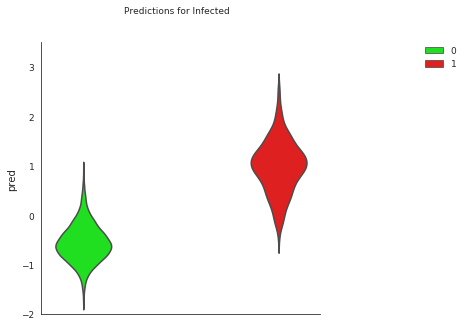

In [15]:
fig = plt.figure(figsize = (5,5))
fig.suptitle('Predictions for Infected', fontsize = 9)
plt.rcParams.update({'axes.titlesize': 'small'})
ax = fig.add_subplot(111)
ax =sns.violinplot(x='Infected', y='pred',scale = 'count', inner = None, 
              hue='Infected', data=DAobserved_calculated, palette=['lime',  'red'], s=1, alpha = 0.2, marker = 'o');
ax.legend(bbox_to_anchor=(1.5, 1),borderaxespad=0, fontsize = 9, frameon = False)

ax.set_ylim([-2, 3.5])
ax.xaxis.label.set_size(10)
ax.yaxis.label.set_size(10)
ax.axes.get_xaxis().set_visible(False)
ax.tick_params(axis='both', which='major', labelsize=9)
sns.despine()
fig.savefig('{}/PLSDA_predictions.{}'.format(OutputDir, 'pdf'),  dpi=300)

In [16]:
DAy_calc = pls_DA.predict(pls_DA_x_values)
observ = pls_DA_y
predict = DAy_calc
roc_auc = roc_auc_score(observ, predict)
print('Area under ROC curve: {:.3f}'.format(roc_auc))

Area under ROC curve: 0.989


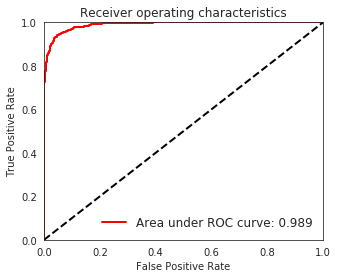

In [17]:
fpr, tpr, _ = roc_curve(observ, predict)

plt.rcParams["figure.figsize"] = (5,4)
plt.figure()
sns.set_style("white")
plt.plot(fpr, tpr, color='red', lw=2
                 ,label='Area under ROC curve: {:0.3f}'.format(roc_auc))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristics', fontdict={'fontsize': 12})
plt.legend(loc="lower right", prop={'size': 12}, frameon = False)
plt.savefig('{}/ROC_area.{}'.format(OutputDir, 'pdf'),  dpi=300);

[0.9792274804658705, 0.9750217507226854, 0.9863849765258216, 0.9795639124293785, 0.9734033964978203]


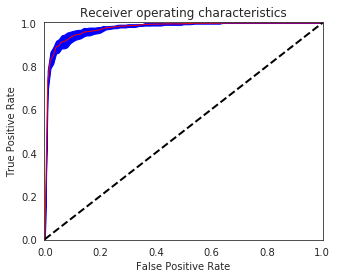

In [18]:
cv = KFold(n_splits=5)
tprs = []
roc_aucs = []
base_fpr = np.linspace(0, 1, 101)

plt.rcParams["figure.figsize"] = (5,4)
plt.figure()
sns.set_style("white")

for i, (train, test) in enumerate(cv.split(pls_DA_x_values, pls_DA_y_values)):
    model = pls_DA.fit(pls_DA_x_values[train], pls_DA_y_values[train]) #.ravel())
    y_score = model.predict(pls_DA_x_values[test])
    fpr, tpr, _ = roc_curve(pls_DA_y_values[test].astype('int'), y_score[:, 0])
    roc_auc = roc_auc_score(pls_DA_y_values[test].astype('int'), y_score[:, 0])
    tpr = np.interp(base_fpr, fpr, tpr)
    tpr[0] = 0.0
    tprs.append(tpr)
    roc_aucs.append(roc_auc)
tprs = np.array(tprs)
mean_tprs = tprs.mean(axis=0)
std = tprs.std(axis=0)

tprs_upper = np.minimum(mean_tprs + 1.15*std, 1)
tprs_lower = mean_tprs - 1.15*std

plt.plot(base_fpr, mean_tprs, 'r',  lw=1)
plt.fill_between(base_fpr, tprs_lower, tprs_upper, color='b')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([-0.003, 1.003])
plt.ylim([-0.003, 1.003])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('Receiver operating characteristics', fontdict={'fontsize': 12})
plt.savefig('{}/Cross-validated_ROC_area.{}'.format(OutputDir, 'pdf'),  dpi=300)
print(roc_aucs)